# RWによる同心円の容量計算  

100%|██████████| 8/8 [00:12<00:00,  1.60s/it]



=== Calculation Results ===
Calculated Capacitance : 5.367e-11 F/m
Theoretical Capacitance: 5.064e-11 F/m
Relative Error        : 5.98%
Average Steps per Walk: 95.4
Total Random Walks    : 32000
Computation Time      : 12.77 seconds



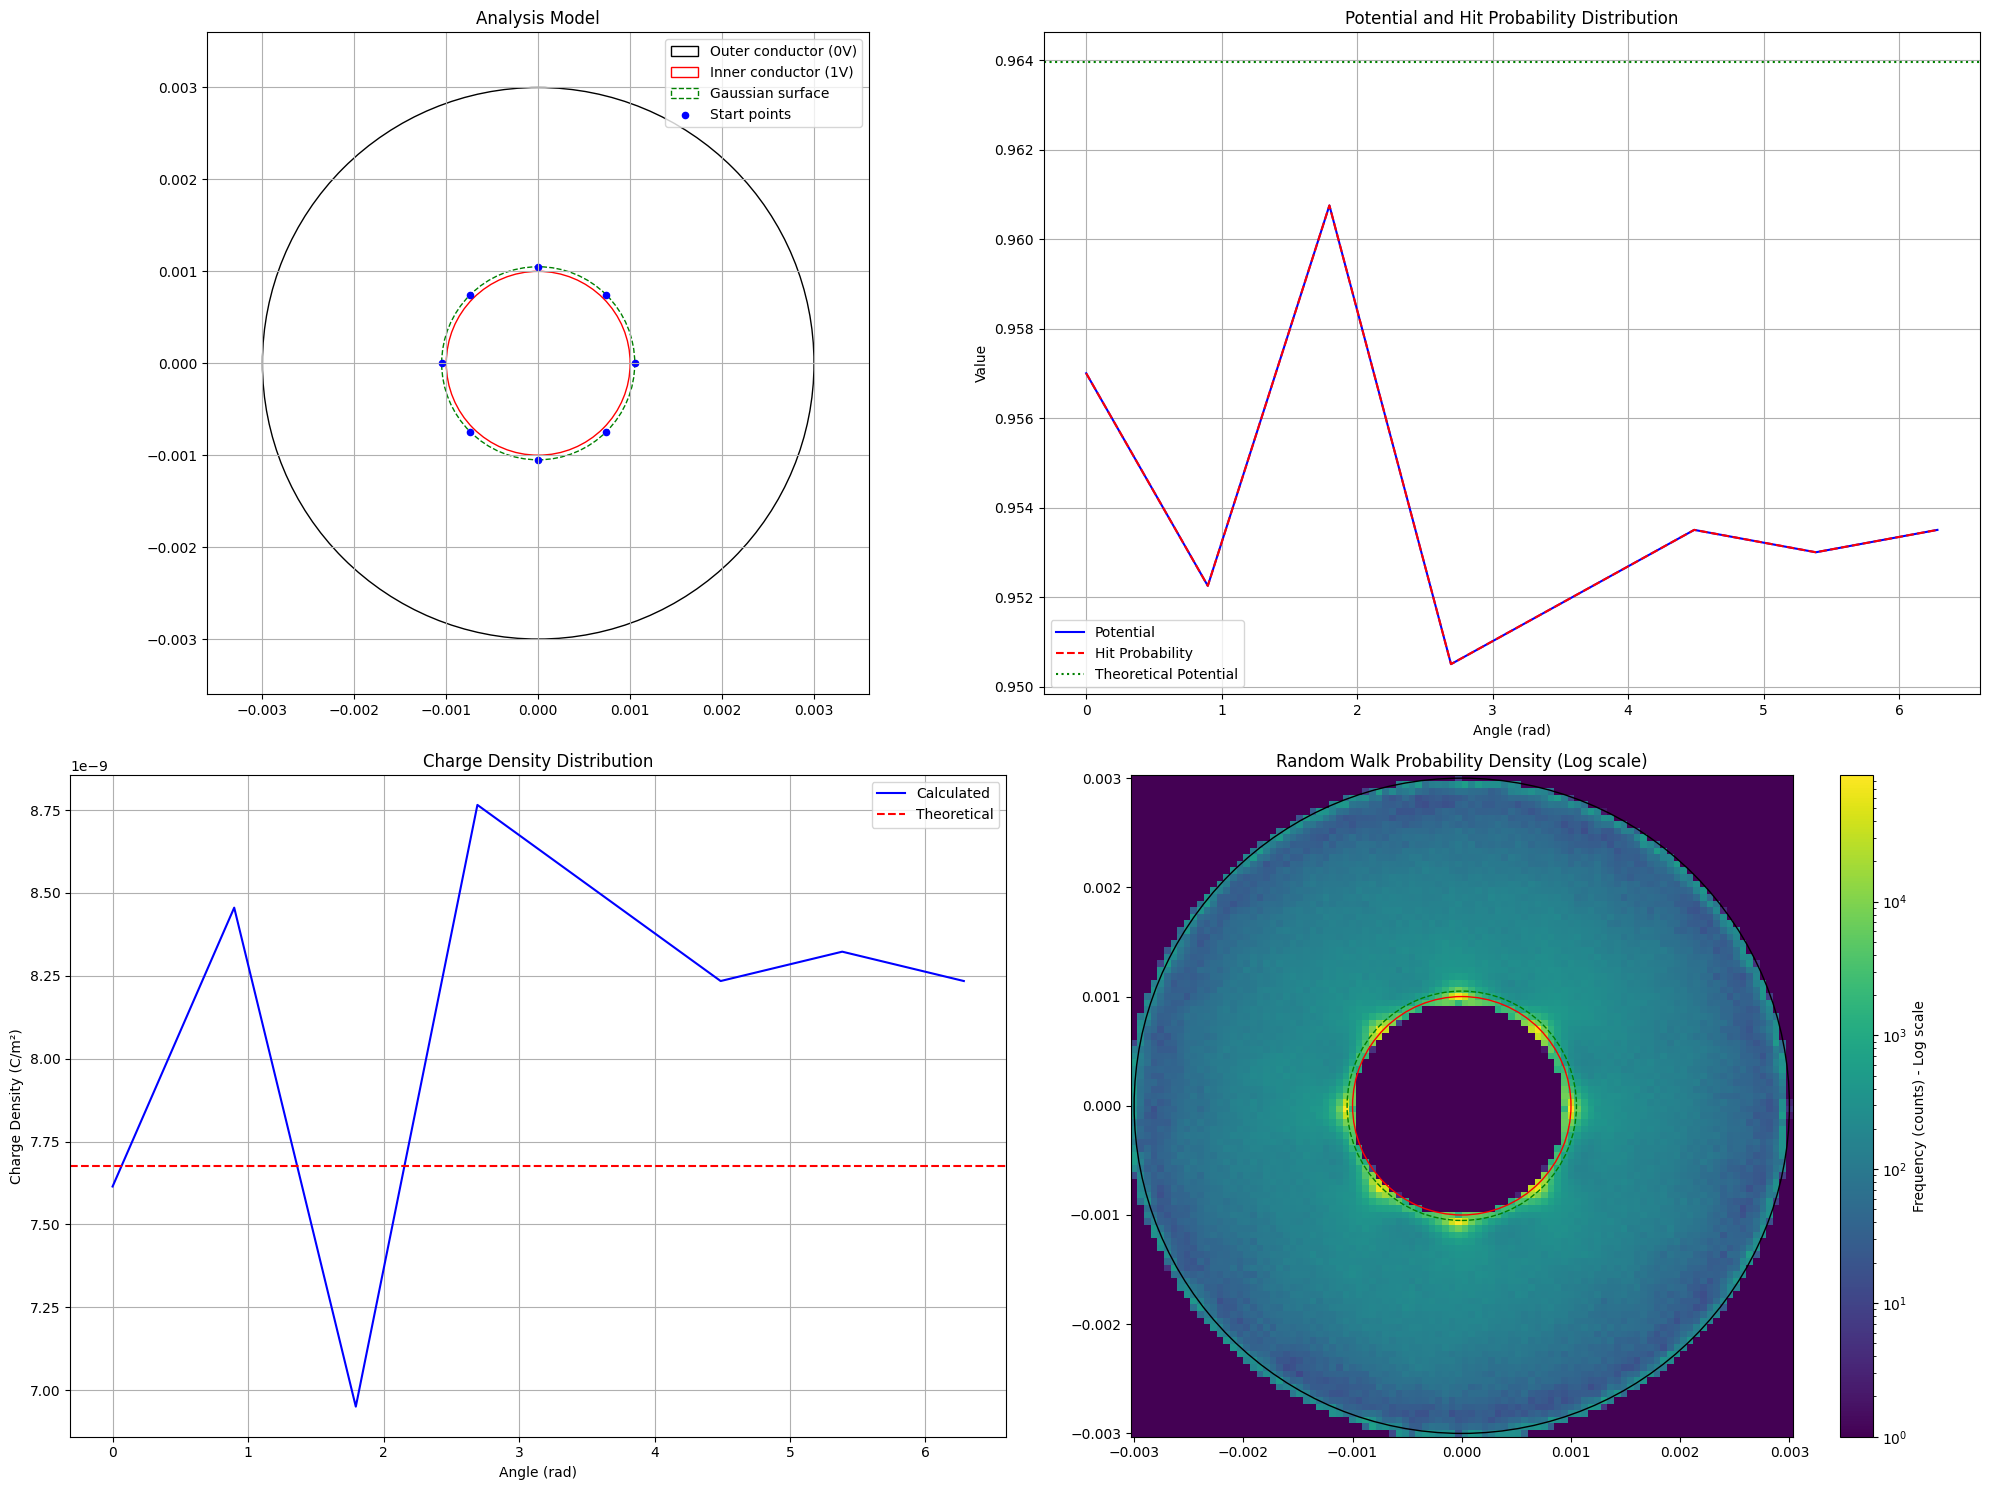

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from tqdm import tqdm
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
import time

class CapacitanceCalculator:
    """同心円形状の容量計算クラス"""
    
    def __init__(
        self,
        inner_radius: float,
        outer_radius: float,
        gaussian_surface_ratio: float,
        num_walks: int,
        base_step_size: float,
        num_gaussian_points: int,
        mesh_size: int = 50,
        batch_size: int = 100  # 基本的なバッチ処理用
    ):
        self.inner_radius = inner_radius
        self.outer_radius = outer_radius
        self.gaussian_radius = inner_radius * gaussian_surface_ratio
        self.num_walks = num_walks
        self.base_step_size = base_step_size
        self.num_gaussian_points = num_gaussian_points
        self.epsilon0 = 8.854e-12
        self.batch_size = batch_size
        
        # メッシュの設定
        self.mesh_size = mesh_size
        self.x_mesh = np.linspace(-outer_radius, outer_radius, mesh_size)
        self.y_mesh = np.linspace(-outer_radius, outer_radius, mesh_size)
        self.density_map = np.zeros((mesh_size, mesh_size))
        self.mesh_scale = (mesh_size - 1) / (2 * outer_radius)
        self.total_steps = 0

        # 基本的な前計算
        self.r2_inner = self.inner_radius ** 2
        self.r2_outer = self.outer_radius ** 2

    def generate_gaussian_points(self) -> np.ndarray:
        """ガウス面上の開始点を生成"""
        theta = np.linspace(0, 2*np.pi, self.num_gaussian_points + 1)[:-1]
        return self.gaussian_radius * np.column_stack((np.cos(theta), np.sin(theta)))

    def update_density_map(self, positions: np.ndarray):
        """密度マップの更新（シンプルな実装）"""
        indices_x = ((positions[:, 0] + self.outer_radius) * self.mesh_scale).astype(int)
        indices_y = ((positions[:, 1] + self.outer_radius) * self.mesh_scale).astype(int)
        
        mask = (indices_x >= 0) & (indices_x < self.mesh_size) & \
               (indices_y >= 0) & (indices_y < self.mesh_size)
        
        for x, y in zip(indices_x[mask], indices_y[mask]):
            self.density_map[y, x] += 1

    def random_walk_batch(self, start_point: np.ndarray) -> Tuple[int, int]:
        """バッチ処理によるランダムウォーク"""
        positions = np.tile(start_point, (self.batch_size, 1))
        total_steps = 0
        hits = 0
        active = np.ones(self.batch_size, dtype=bool)
        
        while active.any():
            # アクティブな点の数を取得
            n_active = active.sum()
            
            # ステップサイズの計算（アクティブな点のみ）
            r = np.sqrt(np.sum(positions[active]**2, axis=1))
            dist_inner = np.abs(r - self.inner_radius)
            dist_outer = np.abs(r - self.outer_radius)
            min_dist = np.minimum(dist_inner, dist_outer)
            
            # 適応的なステップサイズ
            base_step = self.base_step_size * (self.outer_radius - self.inner_radius)
            boundary_step = min_dist * 0.5
            step_sizes = np.where(boundary_step < base_step, boundary_step, base_step)
            step_sizes = np.maximum(step_sizes, 1e-6)
            
            # ランダムな方向への移動
            angles = np.random.random(n_active) * 2 * np.pi
            moves = np.column_stack((
                step_sizes * np.cos(angles),
                step_sizes * np.sin(angles)
            ))
            
            # 位置の更新
            positions[active] += moves
            
            # 密度マップの更新
            self.update_density_map(positions[active])
            
            # 終了判定
            r2 = np.sum(positions[active]**2, axis=1)
            inner_hit = r2 <= self.r2_inner
            outer_hit = r2 >= self.r2_outer
            
            # ヒット数の更新
            hits += inner_hit.sum()
            
            # アクティブな点の更新
            active_indices = np.where(active)[0]
            active[active_indices[inner_hit | outer_hit]] = False
            
            total_steps += n_active

        return hits, total_steps

    def calculate_capacitance(self) -> Tuple[float, Dict]:
        """容量を計算"""
        start_time = time.time()
        self.density_map.fill(0)
        self.total_steps = 0
        
        start_points = self.generate_gaussian_points()
        hit_probabilities = np.zeros(self.num_gaussian_points)
        
        for i, point in enumerate(tqdm(start_points)):
            total_hits = 0
            total_batch_steps = 0
            
            for batch in range(0, self.num_walks, self.batch_size):
                batch_size = min(self.batch_size, self.num_walks - batch)
                if batch_size != self.batch_size:
                    # 最後のバッチサイズが異なる場合の調整
                    temp_batch_size = self.batch_size
                    self.batch_size = batch_size
                    hits, steps = self.random_walk_batch(point)
                    self.batch_size = temp_batch_size
                else:
                    hits, steps = self.random_walk_batch(point)
                
                total_hits += hits
                total_batch_steps += steps
            
            hit_probabilities[i] = total_hits / self.num_walks
            self.total_steps += total_batch_steps

        # 電界と容量の計算
        d = self.gaussian_radius - self.inner_radius
        E = (1 - hit_probabilities) / d
        charge_density = self.epsilon0 * E
        
        ds = self.gaussian_radius * (2 * np.pi / self.num_gaussian_points)
        charge_density_padded = np.append(charge_density, charge_density[0])
        C = np.sum((charge_density_padded[:-1] + charge_density_padded[1:]) * ds) / 2
        
        # 理論値の計算
        C_theoretical = 2 * np.pi * self.epsilon0 / np.log(self.outer_radius / self.inner_radius)
        
        computation_time = time.time() - start_time
        
        results = {
            'potentials': hit_probabilities,
            'charge_density': charge_density_padded,
            'hit_probabilities': hit_probabilities,
            'theoretical_capacitance': C_theoretical,
            'relative_error': abs(C - C_theoretical) / C_theoretical * 100,
            'density_map': self.density_map,
            'max_frequency': np.max(self.density_map),
            'average_steps': self.total_steps / (self.num_walks * self.num_gaussian_points),
            'computation_time': computation_time
        }

        return C, results

    def plot_all_results(self, results: Dict):
        """すべての結果をプロット"""
        fig = plt.figure(figsize=(20, 15))
        
        # 1. 解析モデル図
        ax1 = fig.add_subplot(221)
        self._plot_model(ax1)
        
        # 2. 電位と確率分布
        ax2 = fig.add_subplot(222)
        self._plot_potential_and_probability(ax2, results)
        
        # 3. 電荷密度分布
        ax3 = fig.add_subplot(223)
        self._plot_charge_density(ax3, results)
        
        # 4. ランダムウォーク確率密度分布
        ax4 = fig.add_subplot(224)
        self._plot_walk_density(ax4, results)
        
        plt.tight_layout()
        plt.show()

    def _plot_model(self, ax):
        """解析モデル図の描画"""
        outer = Circle((0, 0), self.outer_radius, fill=False, color='black', label='Outer conductor (0V)')
        inner = Circle((0, 0), self.inner_radius, fill=False, color='red', label='Inner conductor (1V)')
        gaussian = Circle((0, 0), self.gaussian_radius, fill=False, color='green', linestyle='--', 
                        label='Gaussian surface')
        
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(gaussian)
        
        points = self.generate_gaussian_points()
        ax.scatter(points[:, 0], points[:, 1], c='blue', s=20, label='Start points')
        
        ax.set_aspect('equal')
        ax.grid(True)
        ax.legend()
        ax.set_title('Analysis Model')
        
        margin = 0.2
        ax.set_xlim(-self.outer_radius*(1+margin), self.outer_radius*(1+margin))
        ax.set_ylim(-self.outer_radius*(1+margin), self.outer_radius*(1+margin))

    def _plot_potential_and_probability(self, ax, results):
        """電位と確率分布のプロット"""
        theta = np.linspace(0, 2*np.pi, self.num_gaussian_points)
        
        ax.plot(theta, results['potentials'], label='Potential', color='blue')
        ax.plot(theta, results['hit_probabilities'], label='Hit Probability', 
                color='red', linestyle='--')
        
        # 理論値の直線を追加
        r = np.linspace(self.inner_radius, self.outer_radius, 100)
        V_theoretical = 1.0 - np.log(r/self.inner_radius) / np.log(self.outer_radius/self.inner_radius)
        ax.axhline(y=V_theoretical[np.abs(r - self.gaussian_radius).argmin()], 
                  color='green', linestyle=':', label='Theoretical Potential')
        
        ax.set_title('Potential and Hit Probability Distribution')
        ax.set_xlabel('Angle (rad)')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()

    def _plot_charge_density(self, ax, results):
        """電荷密度分布のプロット"""
        theta = np.linspace(0, 2*np.pi, self.num_gaussian_points)
        
        # 計算値
        ax.plot(theta, results['charge_density'][:-1], label='Calculated', color='blue')
        
        # 理論値（一様な電荷密度）
        theoretical_density = self.epsilon0 / (self.gaussian_radius * np.log(self.outer_radius/self.inner_radius))
        ax.axhline(y=theoretical_density, color='red', linestyle='--', label='Theoretical')
        
        ax.set_title('Charge Density Distribution')
        ax.set_xlabel('Angle (rad)')
        ax.set_ylabel('Charge Density (C/m²)')
        ax.grid(True)
        ax.legend()

    def _plot_walk_density(self, ax, results):
        """対数スケールでのランダムウォーク確率密度分布プロット"""
        # 0を含まない最小値を設定
        min_nonzero = np.min(results['density_map'][results['density_map'] > 0])
        plot_data = results['density_map'].copy()
        plot_data[plot_data == 0] = min_nonzero / 2  # 0を最小値の半分で置換
        
        im = ax.pcolormesh(self.x_mesh, self.y_mesh, plot_data,
                          norm=LogNorm(vmin=min_nonzero, vmax=np.max(plot_data)),
                          cmap='viridis')
        
        # モデルの境界を表示
        outer = Circle((0, 0), self.outer_radius, fill=False, color='black')
        inner = Circle((0, 0), self.inner_radius, fill=False, color='red')
        gaussian = Circle((0, 0), self.gaussian_radius, fill=False, color='green', 
                        linestyle='--')
        
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(gaussian)
        
        plt.colorbar(im, ax=ax, label='Frequency (counts) - Log scale')
        
        ax.set_aspect('equal')
        ax.set_title('Random Walk Probability Density (Log scale)')
        
# 使用例
if __name__ == "__main__":
    params = {
        'inner_radius': 0.001,
        'outer_radius': 0.003,
        'gaussian_surface_ratio': 1.05,
        'num_walks': 4000,
        'base_step_size': 1/20,
        'num_gaussian_points': 8,
        'mesh_size': 100,
        'batch_size': 100
    }

    calculator = CapacitanceCalculator(**params)
    C, results = calculator.calculate_capacitance()

    print("\n=== Calculation Results ===")
    print(f"Calculated Capacitance : {C:.3e} F/m")
    print(f"Theoretical Capacitance: {results['theoretical_capacitance']:.3e} F/m")
    print(f"Relative Error        : {results['relative_error']:.2f}%")
    print(f"Average Steps per Walk: {results['average_steps']:.1f}")
    print(f"Total Random Walks    : {params['num_walks'] * params['num_gaussian_points']}")
    print(f"Computation Time      : {results['computation_time']:.2f} seconds")
    print("==========================\n")

    # 結果のプロット
    calculator.plot_all_results(results)

# ガウスポイントの数を変えて１０回解析し、精度を比較する


Analyzing with 4 Gaussian points...


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]



Analyzing with 6 Gaussian points...


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]



Analyzing with 8 Gaussian points...


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Analyzing with 12 Gaussian points...


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Statistical Summary:
Number of Points | Mean Error (%) | Std Error (%)
---------------------------------------------
             4 |         6.70 |        4.76
             6 |         4.48 |        3.47
             8 |         5.02 |        2.51
            12 |         4.66 |        4.05



C:\Users\miken\AppData\Local\Temp\ipykernel_13900\1597047071.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_dict[n] for n in gaussian_points_list],


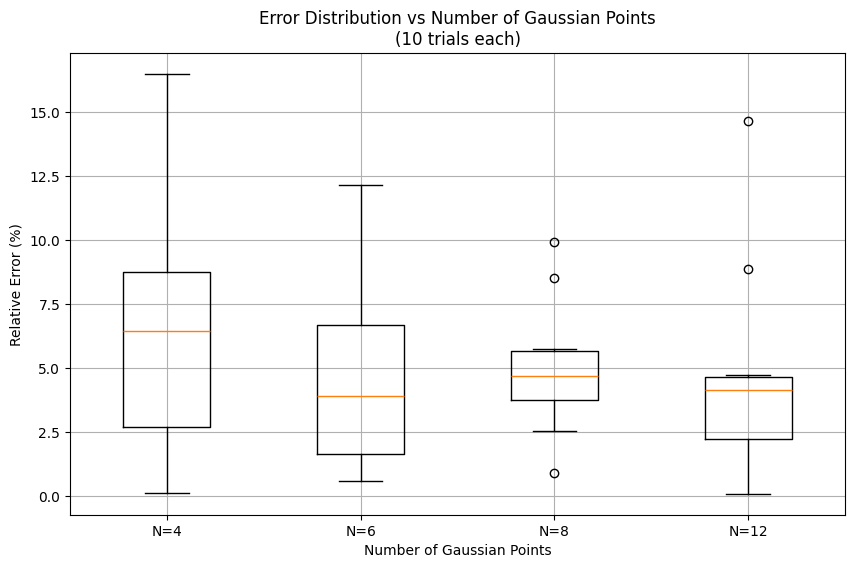

In [5]:
# パラメータの基本設定
base_params = {
    'inner_radius': 0.001,
    'outer_radius': 0.003,
    'gaussian_surface_ratio': 1.01,
    'num_walks': 4000,
    'base_step_size': 1/20,
    'mesh_size': 100,
    'batch_size': 100
}

# 分析するガウスポイントの数
gaussian_points_list = [4, 6, 8, 12]
n_trials = 10

# 結果を格納する辞書
results_dict = {n: [] for n in gaussian_points_list}

# 各ガウスポイント数で10回ずつ計算
for n_points in gaussian_points_list:
    print(f"\nAnalyzing with {n_points} Gaussian points...")
    params = base_params.copy()
    params['num_gaussian_points'] = n_points
    
    for trial in range(n_trials):
        calculator = CapacitanceCalculator(**params)
        C, results = calculator.calculate_capacitance()
        results_dict[n_points].append(results['relative_error'])

# 箱ひげ図でプロット
plt.figure(figsize=(10, 6))
plt.boxplot([results_dict[n] for n in gaussian_points_list], 
            labels=[f'N={n}' for n in gaussian_points_list])

plt.grid(True)
plt.ylabel('Relative Error (%)')
plt.xlabel('Number of Gaussian Points')
plt.title('Error Distribution vs Number of Gaussian Points\n(10 trials each)')

# 具体的な数値も表示
print("\nStatistical Summary:")
print("Number of Points | Mean Error (%) | Std Error (%)")
print("-" * 45)
for n in gaussian_points_list:
    errors = results_dict[n]
    print(f"{n:14d} | {np.mean(errors):12.2f} | {np.std(errors):11.2f}")

plt.show()

Nが増えれば精度は上がる傾向だが、外れ値もあるので、N=8がよさそう。

# ガウス面を変化させて10回解析させて評価　N=8 


Analyzing with gaussian_surface_ratio = 1.01...


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Analyzing with gaussian_surface_ratio = 1.05...


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]



Analyzing with gaussian_surface_ratio = 1.1...


100%|██████████| 8/8 [00:14<00:00,  1.81s/it]



Analyzing with gaussian_surface_ratio = 1.2...


100%|██████████| 8/8 [00:17<00:00,  2.19s/it]



Analyzing with gaussian_surface_ratio = 1.3...


100%|██████████| 8/8 [00:18<00:00,  2.34s/it]



Analyzing with gaussian_surface_ratio = 1.4...


100%|██████████| 8/8 [00:19<00:00,  2.48s/it]



Analyzing with gaussian_surface_ratio = 1.5...


100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


Statistical Summary:
Ratio | Mean Error (%) | Std Error (%)
----------------------------------------
 1.01 |         6.43 |        4.96
 1.05 |         4.35 |        2.32
 1.10 |         5.71 |        2.09
 1.20 |         8.92 |        1.41
 1.30 |        13.82 |        1.18
 1.40 |        18.48 |        0.78
 1.50 |        21.58 |        0.77



C:\Users\miken\AppData\Local\Temp\ipykernel_13900\1060230258.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_dict[ratio] for ratio in ratio_list],


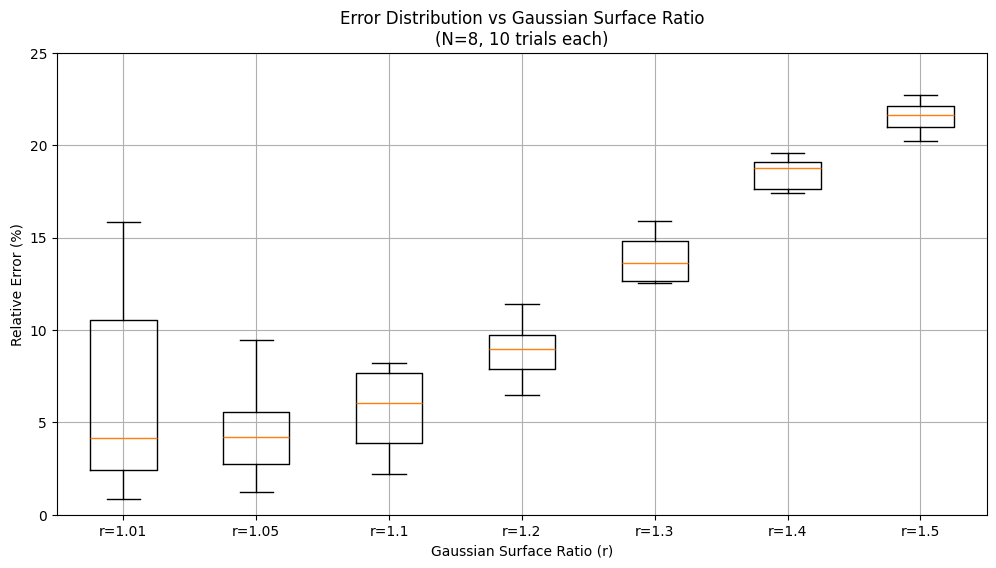


Best gaussian_surface_ratio: 1.05
With mean error: 4.35%


In [7]:
# パラメータの基本設定
base_params = {
    'inner_radius': 0.001,
    'outer_radius': 0.003,
    'num_walks': 4000,
    'base_step_size': 1/20,
    'mesh_size': 100,
    'batch_size': 100,
    'num_gaussian_points': 8  # 固定
}

# 分析するガウス面比率
ratio_list = [1.01, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5]
n_trials = 10

# 結果を格納する辞書
results_dict = {ratio: [] for ratio in ratio_list}

# 各比率で10回ずつ計算
for ratio in ratio_list:
    print(f"\nAnalyzing with gaussian_surface_ratio = {ratio}...")
    params = base_params.copy()
    params['gaussian_surface_ratio'] = ratio
    
    for trial in range(n_trials):
        calculator = CapacitanceCalculator(**params)
        C, results = calculator.calculate_capacitance()
        results_dict[ratio].append(results['relative_error'])

# 箱ひげ図でプロット
plt.figure(figsize=(12, 6))
plt.boxplot([results_dict[ratio] for ratio in ratio_list], 
            labels=[f'r={ratio}' for ratio in ratio_list])

plt.grid(True)
plt.ylabel('Relative Error (%)')
plt.xlabel('Gaussian Surface Ratio (r)')
plt.title('Error Distribution vs Gaussian Surface Ratio\n(N=8, 10 trials each)')

# y軸の範囲を調整（エラーの最小値と最大値に基づいて）
all_errors = [error for errors in results_dict.values() for error in errors]
plt.ylim(min(0, min(all_errors) * 0.9), max(all_errors) * 1.1)

# 結果の統計値を表示
print("\nStatistical Summary:")
print("Ratio | Mean Error (%) | Std Error (%)")
print("-" * 40)
for ratio in ratio_list:
    errors = results_dict[ratio]
    print(f"{ratio:5.2f} | {np.mean(errors):12.2f} | {np.std(errors):11.2f}")

plt.show()

# 最適な比率の推定
mean_errors = {ratio: np.mean(errors) for ratio, errors in results_dict.items()}
best_ratio = min(mean_errors.keys(), key=lambda k: mean_errors[k])
print(f"\nBest gaussian_surface_ratio: {best_ratio}")
print(f"With mean error: {mean_errors[best_ratio]:.2f}%")

1.05 がベストになったが、内円の半径を１、外円の半径を３とすると、  
距離２のばあい0.5 の持つ意味は　2/00.5 = 40分割  　　距離２で電圧１Vなので　1/40 = 0.025V に相当する。  
これを確率になおすと100回に2.5回　外円に到達することになる。